# Import Packages

In [158]:
from tdc.single_pred import Tox
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [159]:


# Load the AMES dataset using TDC library
data = Tox(name = 'AMES')
split = data.get_split()

# Convert dataset splits into pandas DataFrames
train_df = pd.DataFrame(split['train'])
val_df = pd.DataFrame(split['valid'])
test_df = pd.DataFrame(split['test'])


Found local copy...
Loading...
Done!


In [160]:

# Filter datasets to ensure valid binary labels (0 or 1)
train_df = train_df[train_df["Y"].isin([0, 1])]
val_df = val_df[val_df["Y"].isin([0, 1])]
test_df = test_df[test_df["Y"].isin([0, 1])]


In [161]:

def get_descriptor_with_fingerprints(dataset):
  # Extract molecular descriptors from SMILES strings
  data = []
  label = []

  for i in range(len(dataset)):
    smiles = dataset.loc[i, "Drug"]  # Extract SMILES string
    label.append(dataset.loc[i, "Y"])  # Extract label
    mol = Chem.MolFromSmiles(smiles)  # Convert SMILES to RDKit molecule object
    if mol: # Check for valid SMILES
        # Compute molecular descriptors
        fpD1 = Descriptors.FpDensityMorgan1(mol)
        fpD2 = Descriptors.FpDensityMorgan2(mol)
        fpD3 = Descriptors.FpDensityMorgan3(mol)
        mw = Descriptors.ExactMolWt(mol)
        heavyAtom = Descriptors.HeavyAtomCount(mol)
        # Compute Morgan fingerprints
        fingerprints = list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024))


        data.append([fpD1, fpD2, fpD3, mw, heavyAtom] + fingerprints)

  # Create DataFrame with descriptor values and labels
  columns = ['FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'ExactMolWt', "HeavyAtomCount"] + [f'FP_{i}' for i in range(1024)]
  descriptor_df = pd.DataFrame(data, columns=columns)
  descriptor_df['Label'] = label

  return descriptor_df


In [162]:
print("Train:")
print(len(train_df[train_df["Y"] == 1]))
print(len(train_df[train_df["Y"] == 0]))
print("=========================================")
print("Test:")
print(len(test_df[test_df["Y"] == 1]))
print(len(test_df[test_df["Y"] == 0]))
print("=========================================")
print("Val:")
print(len(val_df[val_df["Y"] == 1]))
print(len(val_df[val_df["Y"] == 0]))

print("=========================================")
print("Total:")
print(len(train_df[train_df["Y"] == 1]) + len(test_df[test_df["Y"] == 1]) + len(val_df[val_df["Y"] == 1]))
print(len(train_df[train_df["Y"] == 0]) + len(test_df[test_df["Y"] == 0]) + len(val_df[val_df["Y"] == 0]))

Train:
2759
2335
Test:
798
658
Val:
417
311
Total:
3974
3304


In [163]:

# Generate descriptors for train, validation, and test datasets
descriptor_df_train = get_descriptor_with_fingerprints(train_df)
descriptor_df_val = get_descriptor_with_fingerprints(val_df)
descriptor_df_test = get_descriptor_with_fingerprints(test_df)

# Separate features (X) and labels (y)
X_train, y_train = descriptor_df_train.drop(columns=['Label']), descriptor_df_train['Label']
X_val, y_val = descriptor_df_val.drop(columns=['Label']), descriptor_df_val['Label']
X_test, y_test = descriptor_df_test.drop(columns=['Label']), descriptor_df_test['Label']


In [164]:
descriptor_df_train.head(10)

,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,ExactMolWt,HeavyAtomCount,FP_0,FP_1,FP_2,FP_3,FP_4,...,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023,Label
0,0.782609,1.434783,2.130435,301.110279,23,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0.240000,0.520000,0.860000,646.116486,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.636364,2.272727,2.727273,157.059974,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1.600000,2.300000,2.800000,138.017775,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1.526316,2.263158,2.842105,264.122240,19,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1.750000,2.333333,2.750000,173.043656,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1.178571,1.857143,2.500000,406.154702,28,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,0.666667,0.888889,1.111111,126.065394,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.043478,1.826087,2.608696,307.095691,23,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,1.437500,2.187500,2.937500,234.082684,16,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:


# Train a Gradient Boosting Classifier using all features
clf = GradientBoostingClassifier(
    n_estimators=500,  # Number of trees
    learning_rate=0.05,  # Learning rate
    max_depth=3,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42  # Set random seed for reproducibility
)
clf.fit(X_train, y_train)

# Predict probabilities for train, validation, and test sets
y_train_prob = clf.predict_proba(X_train)[:, 1]
y_val_prob = clf.predict_proba(X_val)[:, 1]
y_test_prob = clf.predict_proba(X_test)[:, 1]

# Compute AUC scores for train, validation, and test sets
auc_train = roc_auc_score(y_train, y_train_prob)
auc_val = roc_auc_score(y_val, y_val_prob)
auc_test = roc_auc_score(y_test, y_test_prob)

# Print AUC scores
print(f"Training AUC: {auc_train}")
print(f"Validation AUC: {auc_val}")
print(f"Test AUC: {auc_test}")

Training AUC: 0.9334054870453171
Validation AUC: 0.8670259933532274
Test AUC: 0.8814142118213467


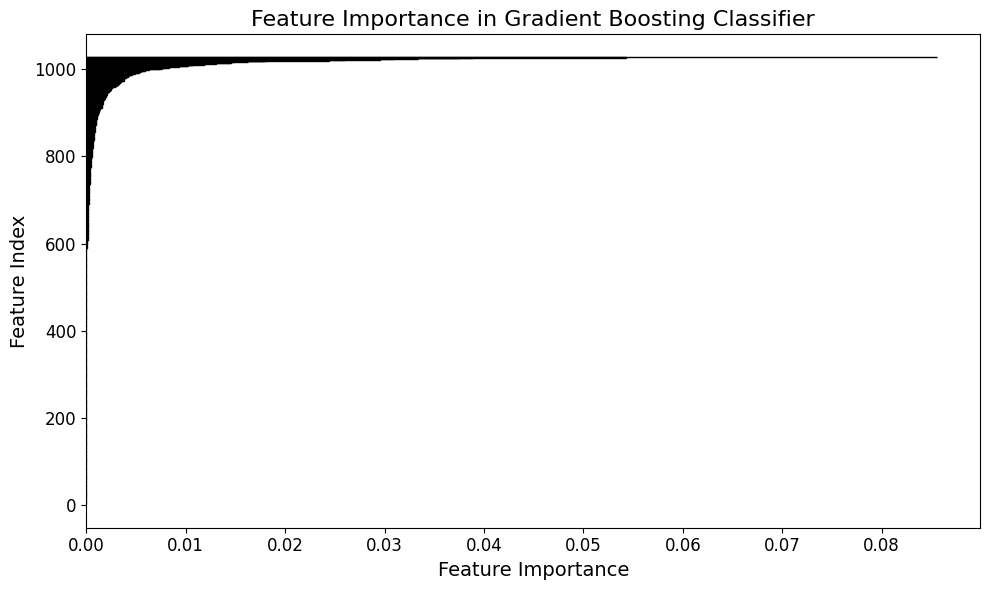

In [166]:
import matplotlib.pyplot as plt

# Extract feature importances
feature_importances = clf.feature_importances_
feature_names = X_train.columns
sorted_indices = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align='center', color='skyblue', edgecolor='black')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature Index', fontsize=14)
plt.title('Feature Importance in Gradient Boosting Classifier', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)  
plt.tight_layout()
plt.show()





In [167]:
# Extract feature names and importances
feature_names = X_train.columns
important_features = sorted(
    zip(feature_names, clf.feature_importances_),
    key=lambda x: x[1],
    reverse=True
)

# Print feature importance for all features in descending order
print("\nFeature Importances (All Features, Ordered High to Low):\n" + "="*60)
for i, (feature, importance) in enumerate(important_features, 1):  # Add index for readability
    print(f"{i}. {feature}: {importance:.6f}")  # Format importance to 6 decimal places

# Print the total count of features
print(f"\nTotal Number of Features: {len(feature_names)}")


Feature Importances (All Features, Ordered High to Low):
1. FP_171: 0.085622
2. ExactMolWt: 0.054287
3. FP_960: 0.038925
4. FP_725: 0.037536
5. FP_979: 0.033408
6. FP_333: 0.030923
7. FpDensityMorgan3: 0.029504
8. FpDensityMorgan1: 0.026056
9. FP_807: 0.024455
10. FP_433: 0.018090
11. FP_659: 0.017908
12. FP_561: 0.016253
13. FP_144: 0.014872
14. FP_549: 0.014582
15. FP_899: 0.014477
16. FP_294: 0.013060
17. FpDensityMorgan2: 0.012033
18. HeavyAtomCount: 0.011802
19. FP_499: 0.010735
20. FP_392: 0.010601
21. FP_389: 0.010203
22. FP_831: 0.010148
23. FP_352: 0.009302
24. FP_753: 0.008443
25. FP_301: 0.008326
26. FP_350: 0.007913
27. FP_487: 0.007688
28. FP_362: 0.007573
29. FP_875: 0.007254
30. FP_587: 0.006325
31. FP_939: 0.005949
32. FP_726: 0.005910
33. FP_26: 0.005841
34. FP_650: 0.005567
35. FP_371: 0.005444
36. FP_910: 0.005387
37. FP_1019: 0.005270
38. FP_695: 0.005045
39. FP_606: 0.004917
40. FP_849: 0.004649
41. FP_728: 0.004593
42. FP_250: 0.004533
43. FP_85: 0.004441
44. FP_


Top 1029 Features:
Training AUC: 0.9332
Validation AUC: 0.8672
Test AUC: 0.8790

Top 800 Features:
Training AUC: 0.9334
Validation AUC: 0.8668
Test AUC: 0.8825

Top 600 Features:
Training AUC: 0.9331
Validation AUC: 0.8662
Test AUC: 0.8818

Top 400 Features:
Training AUC: 0.9329
Validation AUC: 0.8681
Test AUC: 0.8809

Top 200 Features:
Training AUC: 0.9310
Validation AUC: 0.8643
Test AUC: 0.8773

Top 100 Features:
Training AUC: 0.9228
Validation AUC: 0.8610
Test AUC: 0.8752

Top 50 Features:
Training AUC: 0.9086
Validation AUC: 0.8455
Test AUC: 0.8595

Top 10 Features:
Training AUC: 0.8633
Validation AUC: 0.7877
Test AUC: 0.7834


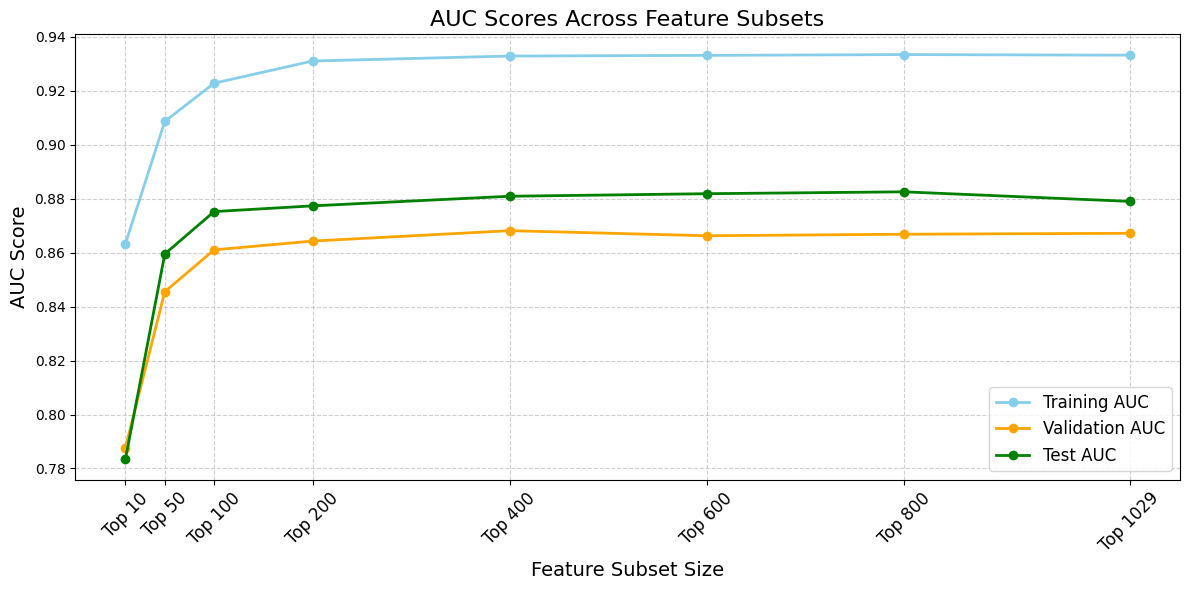

In [168]:
# Define subsets of features to evaluate
subsets = [1029, 800, 600, 400, 200, 100, 50, 10]

# Lists to store AUC scores
train_aucs = []
val_aucs = []
test_aucs = []

# Loop through each subset of features
for subset in subsets:
    # Select the top features for the current subset
    selected_features = [f[0] for f in important_features[:subset]]
    X_train_selected = X_train[selected_features]
    X_val_selected = X_val[selected_features]
    X_test_selected = X_test[selected_features]

    # Train the model
    clf.fit(X_train_selected, y_train)

    # Predict probabilities for train, validation, and test sets
    y_train_prob = clf.predict_proba(X_train_selected)[:, 1]
    y_val_prob = clf.predict_proba(X_val_selected)[:, 1]
    y_test_prob = clf.predict_proba(X_test_selected)[:, 1]

    # Compute AUC scores
    auc_train_selected = roc_auc_score(y_train, y_train_prob)
    auc_val_selected = roc_auc_score(y_val, y_val_prob)
    auc_test_selected = roc_auc_score(y_test, y_test_prob)

    # Append scores to lists
    train_aucs.append(auc_train_selected)
    val_aucs.append(auc_val_selected)
    test_aucs.append(auc_test_selected)

    # Print AUC scores for the current subset
    print(f"\nTop {subset} Features:")
    print(f"Training AUC: {auc_train_selected:.4f}")
    print(f"Validation AUC: {auc_val_selected:.4f}")
    print(f"Test AUC: {auc_test_selected:.4f}")

# Plot the AUC scores
plt.figure(figsize=(12, 6))
plt.plot(subsets, train_aucs, marker='o', label="Training AUC", color='skyblue', linewidth=2)
plt.plot(subsets, val_aucs, marker='o', label="Validation AUC", color='orange', linewidth=2)
plt.plot(subsets, test_aucs, marker='o', label="Test AUC", color='green', linewidth=2)

# Add labels, title, and legend
plt.xlabel("Feature Subset Size", fontsize=14)
plt.ylabel("AUC Score", fontsize=14)
plt.title("AUC Scores Across Feature Subsets", fontsize=16)
plt.xticks(subsets, labels=[f"Top {s}" for s in subsets], rotation=45, fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()
